In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import numpy as np
import torch.nn as nn
import string
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

## Download glove Embedding

In [2]:
# # download glove embeddings from here https://nlp.stanford.edu/projects/glove/
# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip glove.twitter.27B.zip

### Select Glove Embedding dimension and Maximum Sequence Length

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

EMB_DIMENSION = 200 ## avalable dimensions are 25, 50, 100, 200
MAX_SEQ_LENGTH = 96
VECTOR_PATH = f'./glove.twitter.27B/glove.twitter.27B.{EMB_DIMENSION}d.txt'



### Dataset Class

In [4]:
class TwitterDataset(Dataset):

    def __init__(self, data_dir, split='train'):
        """Initialize the attributes of the object of the class."""
        
        # data directory
        self.data_dir = data_dir
        # train or test split
        self.split = split
        # load csv dataset  
        self.df = pd.read_csv(f'{data_dir}/{split}.csv')

        # for train dataset, converts the label into one-hot encoding
        if self.split=='train':
            self.labels = torch.nn.functional.one_hot(torch.tensor(self.df['label'].values))
            
        # load the glove embedding
        self.vector_path = VECTOR_PATH
        
        # set the embedding dimension 50/100/300
        self.emb_dimension = EMB_DIMENSION
        
        # set cuda device if available
        self.device = device
        
        # set the maximum sequence length or max tweet length
        self.max_seq_len = MAX_SEQ_LENGTH
        
        # create the vocabulary from the dataset
        self.vocab = sorted(self._create_vocabulary())
        
        # map word or tokens to index 
        self.word_to_index = {word: idx+1 for idx, word in enumerate(sorted(self.vocab))}
        
        # set pad token index to 0
        self.word_to_index['[PAD]'] = 0
        self.word_to_index['[UNK]'] = len(self.vocab)+1
        
        # create the embedding vector
        self.word_embeddings = self._create_embedding()
        
       
        

    def __len__(self):
        """Return the size of the dataset."""
        return self.df.shape[0]

    def __getitem__(self, index):
        """Return a data sample for a given index, along with the lable of the corresponding tweet"""
        
        
        # - get the data sample corresponding to 'index' (use the list 'self.image_path_list')
        data_sample = self.df.iloc[index]
        
        # tokenize the tweet
        tokens = self._tokenize_text(data_sample['tweet'])

        # use the word_to_index mapping to transform the tokens into indices and save them into an IntTensor
        x = torch.IntTensor([self.word_to_index[word] 
                             if word in self.word_to_index 
                             else self.word_to_index["[UNK]"] 
                             for word in tokens])
        
        
        # transform the variable to cuda or cpu
        x = x.to(self.device)
        
        
        if self.split=='train':
            # get the index-th label and store it into a FloatTensor
            y = self.labels[index].float()
            # transform the variable to cuda or cpu
            y = y.to(self.device)
            # stores the text indices and the label into a dictionary
            features = {'token_ids': x, 'labels': y}
        
        else:
            #for test set only return the token ids
            features = {'token_ids': x}
        
        return features

    def _clean_data(self, data):
        
        """ Remove hyperlinks, mentions, hashtag from the data
            convert to lowercase
            remove non-ASCII characters
            remove the @user tag
            removing stopwords
        """
        

        data = data.lower()
        data = re.sub(r'[^\x00-\x7F]+',' ', data)
        data = re.sub(r"@\S*|#\S*",'',data)
        lines = filter(lambda x: x[0]!= '@' , data.split())
        lines = [word for word in lines if word not in set(stopwords.words('english'))]
        data = " ".join(lines)
        
    
        return data
              
    
    def _create_embedding(self):
        
        """create a matrix containing word vectors"""

        # load the glove embedding to a dict. token is the key and value is the vector
        embeddings_index = {}
        with open(self.vector_path,'r') as file:
            embeddings_index = {line.split()[0]: np.asarray(line.split()[1], dtype='float32') for line in file}

        # create the embedding matrix. keep the words that only present in the dataset. 
        # each row represent one vector
        # row index is the word map index
        embedding_matrix = np.zeros((len(self.word_to_index) + 2, self.emb_dimension))
        for word, i in self.word_to_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
        embedding_matrix[len(self.vocab)+1] = torch.randn(self.emb_dimension)
        return torch.tensor(embedding_matrix, device=self.device)
        
        
    def _create_vocabulary(self):
        """Create a vocabulary of unique words from the given text files."""
        
        
        train_df = pd.read_csv(f'{self.data_dir}/train.csv')
        all_texts = train_df['tweet'].values.tolist()
        letters = string.ascii_lowercase
        word_string = ' '.join(all_texts)
        
        word_string = self._clean_data(word_string)
        
        not_letters = set([char for char in word_string if char not in letters and char != ' '])
        for char in not_letters:
            word_string = word_string.replace(char, " ")
        vocab = set(word_string.split())
        return list(vocab)

    def _tokenize_text(self, tweet):
        """
        Remove non-characters from the text and pads the text to max_seq_len.
        *!* Padding is necessary for ensuring that all text_files have the same size
        *!* This is required since DataLoader cannot handle tensors of variable length

        Return a list of all tokens in the text
        """
        
        tweet = self._clean_data(tweet)
        letters = string.ascii_lowercase
        not_letters = set([char_ for char_ in tweet if char_ not in letters and char_ != ' '])
        for char in not_letters:
            tweet = tweet.replace(char, " ")
        tokens = tweet.split()
        for i in range(self.max_seq_len - len(tokens)):
            tokens.append('[PAD]')
        return tokens
            

         

### Create Dataloaders

In [5]:
dataset_train = TwitterDataset('dataset','train')
# dataset_test = TwitterDataset('dataset','test')

In [6]:
len(dataset_train)

31962

In [7]:
batch_size = 8
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [8]:
# First we define the validation set by splitting the training data into 2 subsets (90% training and 10% validation)
n_train_examples = int(len(dataset_train)*0.70)
n_test_examples = int(len(dataset_train)*0.20)
n_valid_examples = len(dataset_train) - (n_train_examples+n_test_examples) 
train_data, valid_data, test_data = random_split(dataset_train, [n_train_examples,n_valid_examples,n_test_examples])


# We also define the corresponding dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [9]:
print(f"Training Samples: {n_train_examples}")
print(f"Test Samples: {n_test_examples}")
print(f"validaion Samples: {n_valid_examples}")

Training Samples: 22373
Test Samples: 6392
validaion Samples: 3197


In [10]:
# print an example batch

batch_example = next(iter(train_dataloader))
tweet_batch_example = batch_example['token_ids']
labels_batch_example = batch_example['labels']

print(tweet_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 96])
torch.Size([8, 2])


### Create LSTM and GRU model class

In [11]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, word_embeddings,
                 max_sequence_length, num_layers, hidden_size, bidirectional, output_size, act_fn):
        super(LSTM, self).__init__()
        
        # embedding layer: converts tokens ids with respectve word vec
        self.input_layer = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.input_layer.weight.data = word_embeddings
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size = hidden_size, 
                           num_layers = num_layers, 
                           bidirectional=bidirectional, batch_first=True)
        
        if bidirectional:
            self.direction = 2
        else:
            self.direction = 1
            
        self.layers = num_layers
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
            
        self.hidden_size = hidden_size

        # output layer
        self.output_layer = nn.Sequential(nn.Linear(self.direction*hidden_size*max_sequence_length, output_size),act_fn)
    
    def forward(self, x):
        
        # get embedding 
        emb = self.input_layer(x)
        
        batch = x.shape[0]
        # initialize a hidden state and cell state
        h0,c0 = self.init_hidden(batch)
        
        # get output from lstm layers
        l,_ = self.lstm(emb.float(),(h0,c0))
        
        # flatten the output
        l = torch.reshape(l,(batch,-1))
    
        # get final class probabilities
        out = self.output_layer(l)
        
        return out
    
    def init_hidden(self, batch_size):
                
        torch.manual_seed(0)
        h0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=self.device) 
        c0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=self.device)

        return h0,c0

In [12]:
class GRU(nn.Module):
    def __init__(self, vocab_size, emb_dim, word_embeddings,
                 max_sequence_length, num_layers, hidden_size, bidirectional, output_size, act_fn):
        super(GRU, self).__init__()
        
        # embedding layer: converts tokens ids with respectve word vec
        self.input_layer = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.input_layer.weight.data = word_embeddings
        
        # LSTM layer
        self.gru = nn.GRU(input_size=emb_dim, hidden_size = hidden_size, 
                           num_layers = num_layers, 
                           bidirectional=bidirectional, batch_first=True)
        
        if bidirectional:
            self.direction = 2
        else:
            self.direction = 1
            
        self.layers = num_layers
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
            
        self.hidden_size = hidden_size

        # output layer
        self.output_layer = nn.Sequential(nn.Linear(self.direction*hidden_size*max_sequence_length, output_size),act_fn)
    
    def forward(self, x):
        
        # get embedding 
        emb = self.input_layer(x)
        
        batch = x.shape[0]
        # initialize a hidden state and cell state
        h0,c0 = self.init_hidden(batch)
        
        # get output from lstm layers
        l,_ = self.gru(emb.float(),h0)
        
        # flatten the output
        l = torch.reshape(l,(batch,-1))
    
        # get final class probabilities
        out = self.output_layer(l)
        
        return out
    
    def init_hidden(self, batch_size):
                
        torch.manual_seed(0)
        h0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=self.device) 
        c0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=self.device)

        return h0,c0
    

### Training and Evaluation Functions

In [13]:
def evaluation(model, eval_dataloader):
    
    model = copy.deepcopy(model)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for batch in eval_dataloader:

            tweet = batch['token_ids']
            labels = batch['labels']
            # Get the predicted labels
            y_predicted = model(tweet)
            
            # To get the predicted labels, we need to get the max over all possible classes
            label_predicted = torch.argmax(y_predicted.data, 1)
            labels = torch.argmax(labels, 1)
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [14]:

def training(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists to record the training loss over epochs
    loss_all_epochs = []
    val_loss_all_epochs = []
    
    best_accuracy = 0.0
    
    accuracy = []
        
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        val_loss_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, batch in enumerate(train_dataloader):
            
            label = batch['labels']

            optimizer.zero_grad()
            
            out = model_tr.forward(batch['token_ids'])
            l = loss_fn(out,label)
            l.backward()
            optimizer.step()
            loss_current_epoch += (l.item())
            
        for batch_index, batch in enumerate(valid_dataloader):
            label = batch['labels']
            out = model_tr.forward(batch['token_ids'])
            l = loss_fn(out,label)
            val_loss_epoch += loss_fn(out,label).item()
            
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch


        # At the end of each epoch, record and display the loss over all batches
        loss_current_epoch = loss_current_epoch/len(train_dataloader)
        val_loss_epoch = val_loss_epoch/len(valid_dataloader)
        
        loss_all_epochs.append(loss_current_epoch)
        val_loss_all_epochs.append(val_loss_epoch)
        
        acc = evaluation(model_tr, valid_dataloader)
        
        accuracy.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            torch.save(model_tr.state_dict(), f'./models/model-{model.__class__.__name__}.pt')
            
        
        
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_current_epoch: .4f} Valid Loss: {val_loss_epoch: .4f}')
        
    return model_tr, loss_all_epochs, val_loss_all_epochs, accuracy


### Training Hyperparameters

In [15]:
#the vocab size that is built from train set
vocab_size = len(dataset_train.vocab)
# the embedding dimenstion 50/100/300
emb_dim = EMB_DIMENSION
# get the embedding matrix
word_embeddings = dataset_train.word_embeddings
# max sequence length
max_sequence_length = MAX_SEQ_LENGTH

#define lstm layers
num_layers = 5
#define hidden size
hidden_size = 32
#set if LSTM should be bidirectional 
bidirectional = True
# output size i.e class size 
output_size = 2
# activation function
act_fn = nn.Softmax(dim=1)

# since we have binary class, we select Binary cross entroppy loss
loss_fn = nn.BCELoss()

# number of epochs
num_epochs = 5

# learning rate
learning_rate = 0.001




# Training LSTM

In [16]:
# create a RNN  model instance. REMARK: remove .cuda() at the end if gpu is not available
if device!='cpu':
    lstm = LSTM(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
              num_layers,hidden_size, bidirectional, output_size, act_fn).cuda()
else:
    lstm = LSTM(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
              num_layers,hidden_size, bidirectional, output_size, act_fn)


# train model
model_tr_lstm, lstm_loss_all_epochs, lstm_val_loss_all_epochs, lstm_accuracy = training(lstm, 
                                                                                   train_dataloader, 
                                                                                   valid_dataloader,
                                                                                   num_epochs, 
                                                                                   loss_fn, learning_rate)


/home/hossain/Lorraine/Course/Semester 3/Neural Network/Labs/env-nlp/lib/python3.10/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/5], Train Loss:  0.2246 Valid Loss:  0.1960
Epoch [2/5], Train Loss:  0.1244 Valid Loss:  0.1846
Epoch [3/5], Train Loss:  0.0758 Valid Loss:  0.2116
Epoch [4/5], Train Loss:  0.0522 Valid Loss:  0.2691
Epoch [5/5], Train Loss:  0.0380 Valid Loss:  0.2816


# Visualization LSTM 

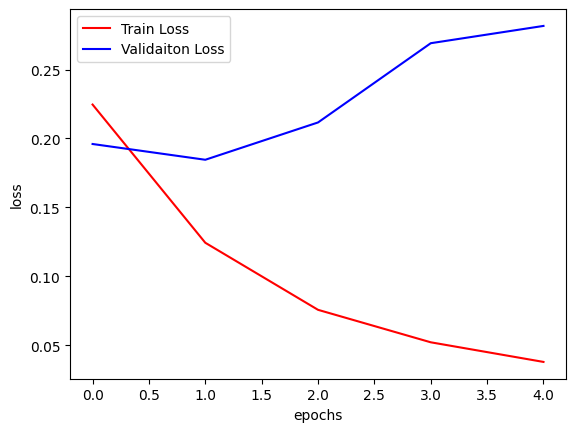

In [17]:
plt.figure()
epochs = [i for i in range(num_epochs)]
plt.plot(epochs, lstm_loss_all_epochs, 'r', label='Train Loss')
plt.plot(epochs, lstm_val_loss_all_epochs, 'b', label='Validaiton Loss')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend()
plt.show()

# Training GRU

In [18]:
if device!='cpu':
    gru = GRU(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
          num_layers, hidden_size, bidirectional, output_size, act_fn).cuda()
else:
    gru = GRU(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
          num_layers, hidden_size, bidirectional, output_size, act_fn)

# since we have binary class, we select Binary cross entroppy loss
loss_fn = nn.BCELoss()
# number of epochs
num_epochs = 5

# learning rate
learning_rate = 0.001

# train model
model_tr_gru, gru_loss_all_epochs, gru_val_loss_all_epochs, gru_accuracy = training(gru, 
                                                                                train_dataloader, 
                                                                                valid_dataloader, 
                                                                                num_epochs, loss_fn, learning_rate)


/home/hossain/Lorraine/Course/Semester 3/Neural Network/Labs/env-nlp/lib/python3.10/site-packages/torch/nn/modules/rnn.py:950: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/5], Train Loss:  0.2166 Valid Loss:  0.1796
Epoch [2/5], Train Loss:  0.1146 Valid Loss:  0.2094
Epoch [3/5], Train Loss:  0.0682 Valid Loss:  0.2644
Epoch [4/5], Train Loss:  0.0434 Valid Loss:  0.3492
Epoch [5/5], Train Loss:  0.0283 Valid Loss:  0.3575


# Visualization GRU 

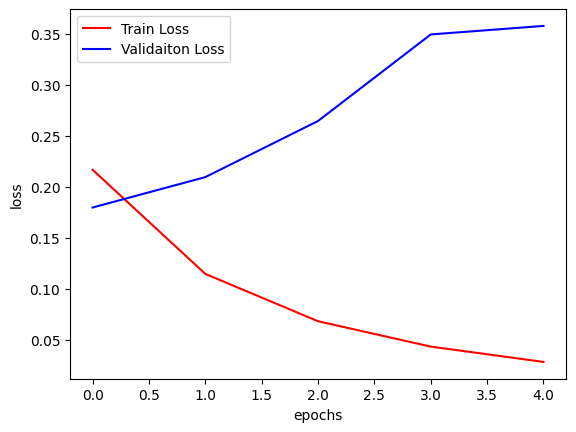

In [19]:
plt.figure()
epochs = [i for i in range(num_epochs)]
plt.plot(epochs, gru_loss_all_epochs, 'r', label='Train Loss')
plt.plot(epochs, gru_val_loss_all_epochs, 'b', label='Validaiton Loss')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluation on Test Set

In [25]:
best_lstm = LSTM(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
          num_layers,hidden_size, bidirectional, output_size, act_fn).cuda()
best_lstm.load_state_dict(torch.load(f'./models/model-{best_lstm.__class__.__name__}.pt'))
best_lstm.eval()
acc_lstm = evaluation(best_lstm, test_dataloader)

In [21]:
print(f'Accuracy LSTM: {acc_lstm: .2f}')

Accuracy LSTM:  94.68


In [26]:
best_gru = GRU(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
          num_layers,hidden_size, bidirectional, output_size, act_fn).cuda()
best_gru.load_state_dict(torch.load(f'./models/model-{best_gru.__class__.__name__}.pt'))
best_gru.eval()
acc_gru = evaluation(best_gru, test_dataloader)

In [23]:
print(f'Accuracy GRU: {acc_gru: .2f}')

Accuracy GRU:  94.79
